In [1]:
%matplotlib inline
from astropy import units as u
from plasmapy import formulary
from plasmapy import particles
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

# Physics of the ExB drift

Consider a single particle of mass $m$ and charge $q$ in a constant, uniform magnetic field $\mathbf{B}=B\ \hat{\mathbf{z}}$. In the absence of external forces, it travels with velocity $\mathbf{v}$ governed by the equation of motion
$$m\frac{d\mathbf{v}}{dt} = q\mathbf{v}\times\mathbf{B}$$
which simply equates the net force on the particle to the corresponding Lorentz force. Assuming the particle initially (at time $t=0$) has $\mathbf{v}$ in the $x,z$ plane (with $v_y=0$), solving reveals 
$$v_x = v_\perp\cos\omega_c t \quad\mathrm{;}\quad v_y = -\frac{q}{\lvert q \rvert}v_\perp\sin \omega_c t$$
while the parallel velocity $v_z$ is constant. This indicates that the particle gyrates in a circular orbit in the $x,y$ plane with constant speed $v_\perp$, angular frequency $\omega_c = \frac{\lvert q\rvert B}{m}$, and Larmor radius $r_L=\frac{v_\perp}{\omega_c}$.

As an example, take one proton `p+` moving with velocity $1\ m/s$ in the $x$-direction at $t=0$:

In [2]:
# Setup proton in uniform B field
B = 5 * u.T
proton = particles.Particle('p+')
omega_c = formulary.parameters.gyrofrequency(B,proton)
v_perp = 1 * u.m/u.s
r_L = formulary.parameters.gyroradius(B,proton,Vperp=v_perp)

<Quantity 2.08793698e-09 m>

We can define a function that evolves the particle's position according to the relations above describing $v_x,v_y$, and $v_z$. The option to add a constant drift velocity $v_d$ to the solution is included as an argument, though this drift velocity is zero by default:

In [3]:
def single_particle_trajectory(v_d=np.array([0,0,0])):
    # Set time resolution & velocity such that proton goes 1 meter along B per rotation
    T = 2*math.pi/omega_c.value  # rotation period
    v_parallel = 1/T * u.m/u.s 
    dt = T/1e2 * u.s

    # Set initial particle position
    x = []; y = []
    xt = 0 * u.m; yt = -r_L;
    
    # Evolve motion
    timesteps = np.arange(0,10*T,dt.value)
    for t in list(timesteps):
        v_x = v_perp*math.cos(omega_c.value*t) + v_d[0]
        v_y = v_perp*math.sin(omega_c.value*t) + v_d[1]
        xt += + v_x*dt
        yt += + v_y*dt
        x.append(xt.value)
        y.append(yt.value)
    x = np.array(x)
    y = np.array(y)
    z = v_parallel.value*timesteps
    
    return x, y, z

Executing with the default argument and plotting the particle trajectory gives the expected helical motion, with a radius equal to the Larmor radius:

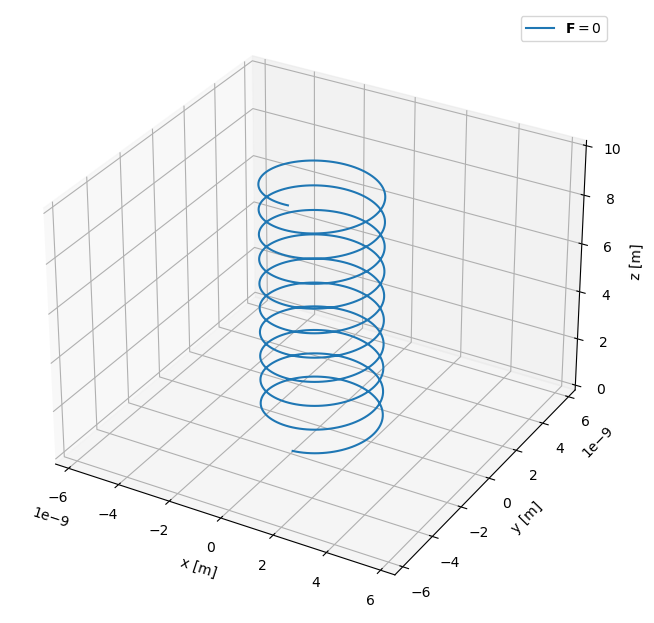

r_L = 2.09e-09 m
omega_c = 4.79e+08 rads/s


In [4]:
x, y, z = single_particle_trajectory()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z, label='$\mathbf{F}=0$')
ax.legend()
bound = 3*r_L.value
ax.set_xlim([-bound,bound])
ax.set_ylim([-bound,bound])
ax.set_zlim([0,10])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

print(f'r_L = {r_L.value:.2e} m')
print(f'omega_c = {omega_c.value:.2e} rads/s')

How does this motion change when a constant external force $\mathbf{F}$ is added? The new equation of motion is

$$m\frac{d\mathbf{v}}{dt} = q\mathbf{v}\times\mathbf{B} + \mathbf{F}$$

and we can find a solution by considering velocities of the form $\mathbf{v}=\mathbf{v}_\parallel + \mathbf{v}_L + \mathbf{v}_d$. Here, $\mathbf{v}_\parallel$ is the velocity parallel to the magnetic field, $\mathbf{v}_L$ is the Larmor gyration velocity in the absence of $\mathbf{F}$ found previously, and $\mathbf{v}_d$ is some constant drift velocity perpendicular to the magnetic field. Then, we find that

$$F_\parallel = m\frac{dv_\parallel}{dt} \quad\mathrm{and}\quad \mathbf{F}_\perp = q\mathbf{B}\times \mathbf{v}_d$$

and applying the vector triple product yields


$$\mathbf{v}_d = \frac{1}{q}\frac{\mathbf{F}_\perp\times\mathbf{B}}{B^2}$$

In the case where the external force $\mathbf{F} = q\mathbf{E}$ is due to a constant electric field, this is the constant $\mathbf{E}\times\mathbf{B}$ drift velocity:
$$\boxed{
    \mathbf{v}_d = \frac{\mathbf{E}\times\mathbf{B}}{B^2}
    }$$
Built in drift functions allow you to account for the new force added to the system in two different ways:

In [5]:
E = 0.2 * u.V/u.m  # E-field magnitude
ey = np.array([0, 1, 0])
ez = np.array([0, 0, 1])
F = proton.charge*E  # force due to E-field

v_d = formulary.drifts.force_drift(F*ey,B*ez,proton.charge)
print('F drift velocity: ',v_d)
v_d = formulary.drifts.ExB_drift(E*ey,B*ez)
print('ExB drift velocity: ',v_d)

F drift velocity:  [0.04 0.   0.  ] m / s
ExB drift velocity:  [0.04 0.   0.  ] m / s


The resulting particle trajectory can be compared to the case without drifts by calling our previously defined function with the drift velocity now as an argument. As expected, there is a constant drift in the direction of $\mathbf{E}\times\mathbf{B}$:

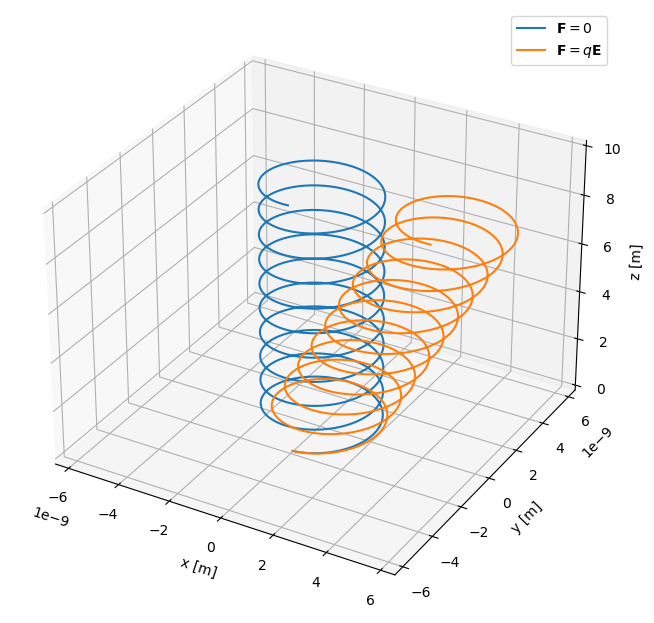

r_L = 2.09e-09 m
omega_c = 4.79e+08 rads/s


In [6]:
x_d, y_d, z_d = single_particle_trajectory(v_d=v_d)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z, label='$\mathbf{F}=0$')
ax.plot(x_d, y_d, z_d, label='$\mathbf{F}=q\mathbf{E}$')
ax.legend()
bound = 3*r_L.value
ax.set_xlim([-bound,bound])
ax.set_ylim([-bound,bound])
ax.set_zlim([0,10])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

print(f'r_L = {r_L.value:.2e} m')
print(f'omega_c = {omega_c.value:.2e} rads/s')

Of course, the implementation in our `single_particle_trajectory()` function requires the analytical solution for the velocity $\mathbf{v}_d$. This solution can be compared with that implemented in the [particle stepper notebook](https://docs.plasmapy.org/en/stable/notebooks/particle_stepper.html). It uses the Boris algorithm to evolve the particle along its trajectory in prescribed $\mathbf{E}$ and $\mathbf{B}$ fields, and thus does not require the analytical solution.